# Transfer Learning

In [34]:
!nvidia-smi
!pwd
isLocalServer = True

Tue Aug 30 15:04:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |   9129MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

def path_add_to_sys_path(path_to_be_add):
  # path_to_be_add = '/notebook/personal/ksuchoi216/face-id-model/'
  if not path_to_be_add in sys.path:
    sys.path.insert(0, path_to_be_add)
    os.chdir(path_to_be_add)

  print(f'sys.path: {sys.path}')

if isLocalServer is True:
  path_add_to_sys_path('/notebook/personal/ksuchoi216/face-id-model/')
  
from utils import load_config
cfg = load_config('config_model.json')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sys.path: ['/notebook/personal/ksuchoi216/face-id-model/', '/notebook', '/root/.pyenv/versions/3.9.1/lib/python39.zip', '/root/.pyenv/versions/3.9.1/lib/python3.9', '/root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload', '', '/root/.pyenv/versions/python39/lib/python3.9/site-packages']


250
 data 
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
batch_size: 4 

dataset length: (1079) = tr (863) + val (107) + tt (109)
image dimension: (3, 250, 250)


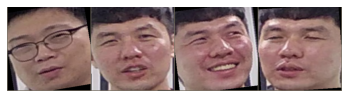

input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 3
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 3
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 3
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 1


In [36]:
from datasets import Folder_Dataset
from utils import imshow_dataloader
folder_Dataset = Folder_Dataset(cfg['data'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

# show a example picture 
image_size = imshow_dataloader(dataloaders["train"])

phase="train"
for i, (inputs, labels) in enumerate(dataloaders[phase]):
  if i > 3:
    break
  
  print(f'input shape: {inputs[0].shape} / label shape: {labels[0].shape} / label: {labels[0]}')
  

In [18]:
from modules import Builder

builder = Builder(cfg['model'])
builder.summary()
model = builder.getModel()

# declaration for learning and testing|
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device is cuda:0
Loading model was just completed.
InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running

In [21]:
from modules import runner
phases = ['train', 'val']
# print(runner)
model, train_evaluation_matrix, val_evaluation_matrix = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=30)

Epoch 0/29
train Loss: 0.2595 Acc: 0.9200 recall: 0.9215 Precision: 0.9210
val Loss: 0.0566 Acc: 0.9813 recall: 0.9278 Precision: 0.9277
----------------------------------------------------------------------------------------------------
Epoch 1/29
train Loss: 0.2090 Acc: 0.9363 recall: 0.9385 Precision: 0.9371
val Loss: 0.0551 Acc: 0.9813 recall: 0.9429 Precision: 0.9421
----------------------------------------------------------------------------------------------------
Epoch 2/29
train Loss: 0.2023 Acc: 0.9351 recall: 0.9354 Precision: 0.9363
val Loss: 0.0598 Acc: 0.9813 recall: 0.9404 Precision: 0.9414
----------------------------------------------------------------------------------------------------
Epoch 3/29
train Loss: 0.2096 Acc: 0.9374 recall: 0.9388 Precision: 0.9366
val Loss: 0.0482 Acc: 0.9720 recall: 0.9422 Precision: 0.9406
----------------------------------------------------------------------------------------------------
Epoch 4/29
train Loss: 0.2120 Acc: 0.9235 recall

30 4


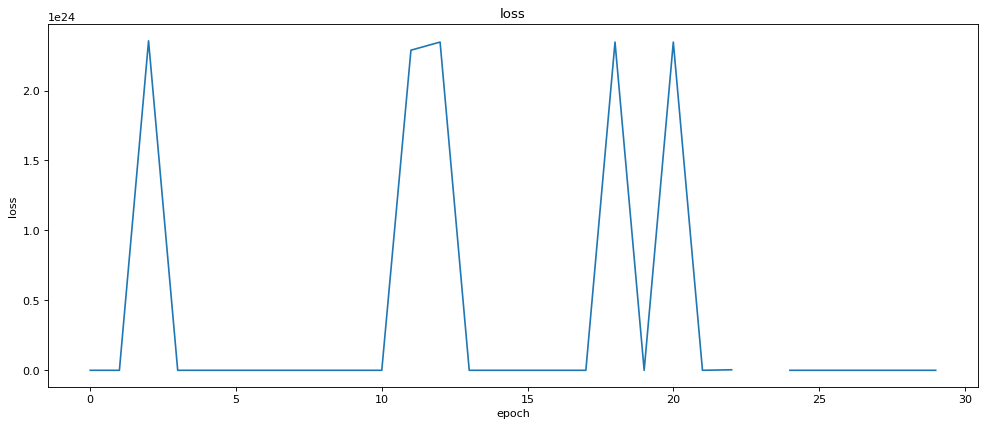

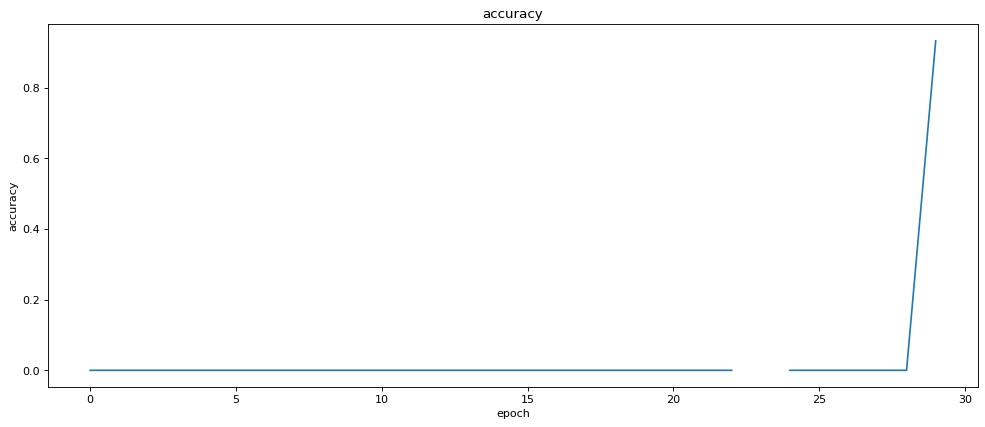

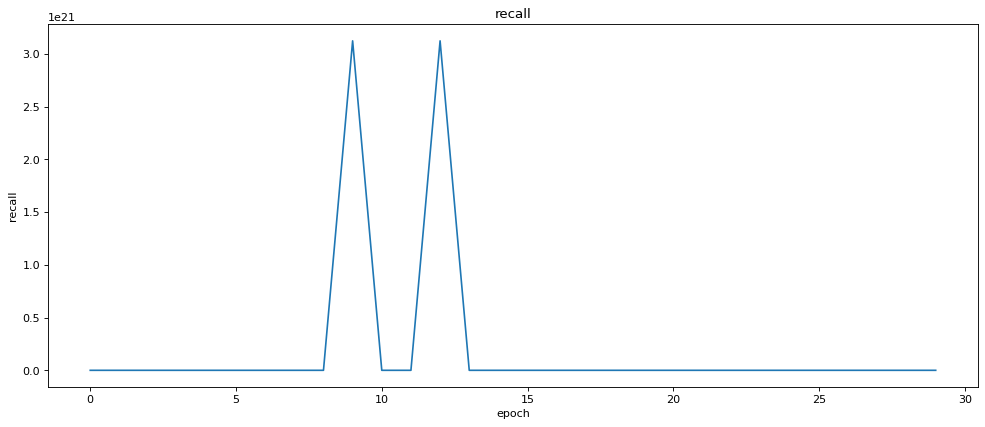

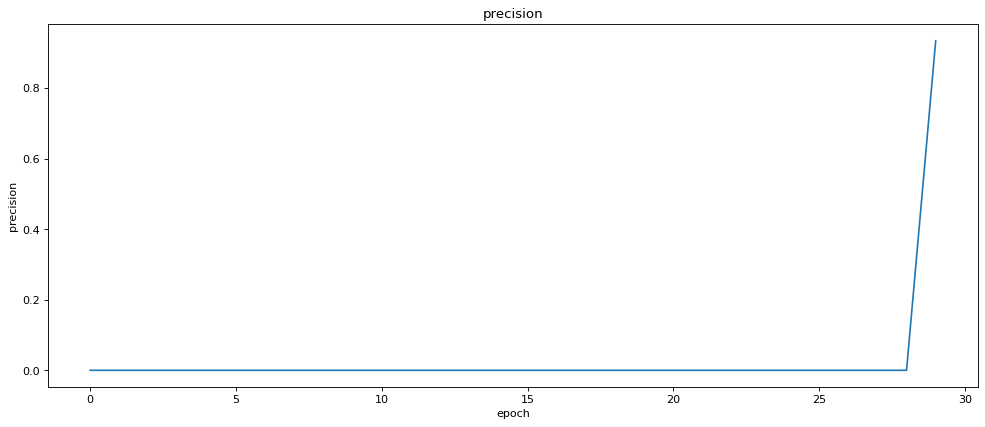

In [23]:
train_evaluation_numpy = train_evaluation_matrix.to('cpu').numpy()
val_evaluation_numpy = val_evaluation_matrix.to('cpu').numpy()

num_epochs, num_evaluations = train_evaluation_numpy.shape
print(num_epochs, num_evaluations)

title_list = ['loss', 'accuracy', 'recall', 'precision']
for col, title in zip(range(0, num_evaluations), title_list):
  plt.figure(figsize=(15, 6), dpi=80)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.plot(range(0, num_epochs), train_evaluation_numpy[:, col])
  plt.show()

In [24]:
phases = ['test']
runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)

Epoch 0/0
test Loss: 0.0235 Acc: 1.0000 recall: 1.0000 Precision: 1.0000
----------------------------------------------------------------------------------------------------
Training complete in 0m 2s
Best val Acc: 0.000000
there is no return value becasue of test mode


## Save trained model

In [27]:
cfg = load_config('config_model.json')
path_for_saving_model = cfg['path_for_saving_model']
try: 
  torch.save(model.state_dict(), path_for_saving_model)
  print(f'successfully saved model in {path_for_saving_model}')
except:
  print(f'failed saving model in {path_for_saving_model}')

successfully saved model in ./data/face-extraction-model.pt


# [TEST] face_feature_extractor with trained classifier(last layer)

In [28]:
phases = ['test']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for phase in phases:
  for i, (inputs, labels) in enumerate(dataloaders[phase]):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    print('outputs before softmax:', outputs)
    outputs = F.softmax(outputs)
    print('outputs after softmax:', outputs)
    values, preds = torch.max(outputs, 1)
    print(values)
    
    
    print('\n')
    if i > 2:
      break
    

outputs before softmax: tensor([[ 8.6773, -3.5494, -2.2629, -2.7293],
        [-0.0917, -0.9950,  5.0859, -3.4755],
        [-3.0597, -1.9824,  0.2214,  4.5652],
        [-1.2542,  5.4428, -2.4995, -1.3054]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[9.9997e-01, 4.8978e-06, 1.7731e-05, 1.1122e-05],
        [5.5963e-03, 2.2678e-03, 9.9195e-01, 1.8980e-04],
        [4.8097e-04, 1.4126e-03, 1.2796e-02, 9.8531e-01],
        [1.2312e-03, 9.9724e-01, 3.5443e-04, 1.1698e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([1.0000, 0.9919, 0.9853, 0.9972], device='cuda:0',
       grad_fn=<MaxBackward0>)


outputs before softmax: tensor([[-1.4975, -2.7416, -1.7235,  5.8713],
        [ 7.8332, -1.5961, -1.7431, -3.0069],
        [-1.8632, -0.6345, -2.2530,  4.5594],
        [-0.7811, -1.6919, -1.4556,  5.3402]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[6.2975e-04, 1.8150e-04, 5.0237e-04, 9.9869e-01],
  